## Logistic Regression with IRLS
This is an implementation of logistic regression in Python using only NumPy. Maximum likelihood estimation is performed using the method of [iteratively re-weighted least squares (IRLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).



#### Contents
1. [Data Ingestion](#Ingestion)
2. [Model Specification](#Specification)
3. [Model Fitting](#Fitting)
4. [Complete Algorithm and Analysis](#Complete)
5. [Sources](#Sources)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='Ingestion'></a>
### 1. Data Ingestion
The read_dataset() function defined here can be used to read numerical data and create a LogisticModel. The LogisticModel class will be defined further below.

We will first walk through the theory, algorithm and Python code before piecing it all together in the LogisticModel fit() method.

In [2]:
def read_dataset(path, name='logistic', data_only = False):
    
    """   
    Given a .csv file path, separates the responsevector y from the data matrix X.
    Assumes all columns have headings, are numerical, and the response vector is the first column.
    Returns an instance of LogisticModel with the following attributes:
        name: provided name for model
        varnames: tuple of variable names
        y: the response vector,
        X: the predictor matrix, with an additional dummy variable of 1's for the intercept coefficient
        
    Alternatively, returns the numpy arrays only as a tuple (y,X)
    """
        
    data_struc = np.genfromtxt(path, dtype=float, names=True, delimiter=",")
    data_array = data_struc.view((float, len(data_struc.dtype.names)))
    split_data = np.split(data_array, indices_or_sections=[1], axis=1)
    varnames = data_struc.dtype.names
    y = split_data[0].flatten()
    X = np.concatenate((np.ones_like(split_data[0].flatten(), dtype='float64')[:, np.newaxis], split_data[1]), axis=1)
    
    if data_only:
        return (y,X)
    else:
        return(LogisticModel(name,varnames,y,X))

<a id='Specification'></a>
### 2. Model Specification
For logistic regression, we model the probability of each $Y_{i}$ conditioned on the $m$ explanatory variables as the outcome of a Bernoulli-distributed random variable:

$$Y_{i}\mid x_{1,i},...,x_{m,i}\sim \mathrm{Bernoulli}(p_{i})$$

Each Bernoulli has a single parameter, $p_{i}$, the probability of a success and expected value.

The model is specified using the logit transformation so that the predicted log-odds is a linear function of the explanatory variables, $\mathbf{x}$, and the predicted probability will be between 0 and 1:

$$\log\frac{p(\mathbf{x}_{i})}{1-p(\mathbf{x}_{i})} = \mathbf{w}^{T}\mathbf{x}_{i}$$

$$p(\mathbf{x}_{i}) = \frac{1}{1+e^{-\mathbf{w}^{T}\mathbf{x}_{i}}}$$

where $\mathbf{w}$ is a vector of size $m+1$ containing the coefficients and intercept.


#### Python:
```python
# y is the response vector,
# X is the predictor matrix, with an additional dummy variable of 1's for the intercept coefficient    

w = np.array([0]*X.shape[1], dtype='float64') # create our coefficient vector
y_bar = np.mean(y)
w_init = math.log(y_bar/(1-y_bar)) # our intitial estimate of the coefficients
h = w_init + X.dot(w) # create a vector of linear predictors
p = 1/(1+np.exp(-h)) # create a vector of fitted values
```

<a id='Fitting'></a>
### 3. Model Fitting

I’ve used the method of Iteratively Reweighted Least Squares (IRLS) to find the maximum likelihood estimate. In this case, IRLS is equivalent to Newton's method, a second-order optimization algorithm.

Assuming $n$ independent Bernoulli trials, we have a combined likelihood function for our training data:

$$L(\mathbf{w}) = \prod_{i=1}^{n}p(\mathbf{x}_{i})^{y_{i}}(1-p(\mathbf{x}_{i})^{1-y_{i}})$$

and the negative log-liklihood, which we seek to minimize:

$$\mathrm{NLL}(\mathbf{w})=-\sum_{i=1}^{n}y_{i}\log p_{i}+(1-y_{i})\log (1-p_{i})$$

We can be sure that the algorithm will converge to a unique NLL because [the function is strictly convex](http://qwone.com/~jason/writing/convexLR.pdf). Newton’s method consists of taking a series of $k$ "Newton steps" of size $-\mathbf{H}_{k}^{-1}\mathbf{g}_{k}$, where $\mathbf{g}$ is the gradient and $\mathbf{H}$ is the Hessian of $\mathrm{NLL}$:

$$\mathbf{g} = \frac{d}{d\mathbf{w}}f(\mathbf{w})= \sum_{i=1}^{n}(p_{i}-y_{i})\mathbf{x}_{i}=\mathbf{X}^T(\mathbf{p}-\mathbf{y})$$

$$\mathbf{H} = \frac{d}{d\mathbf{w}}g(\mathbf{w})^T=\sum_{i=1}^{n}(\nabla_{\mathbf{w}}p_{i})\mathbf{x}_{i}^T=\sum_{i=1}^{n}p_i(1-p_i)\mathbf{x}_i\mathbf{x}_i^T=\mathbf{X}^T\mathbf{SX}$$

$$\mathbf{S}=\mathrm{diag}(p_i(1-p_i))$$

$\mathbf{S}$ is a diagonal weighting matrix that simplifies each iteration to solving a weighted least squares problem. Each sample will be repeatedly re-weighted inverse to its estimated variance, $p_i(1-p_i)$ (also the derivative of $p$ with respect to the linear predictor). Our original Newton steps can be simplified:

$$\mathbf{w}_{k+1}=\mathbf{w}_k-\mathbf{H}^{-1}\mathbf{g}_k$$

$$\mathbf{w}_{k+1}=(\mathbf{X}^T\mathbf{S}_k\mathbf{X})^{-1}\mathbf{X}^T\mathbf{S}_k\mathbf{z}_k$$

where $\mathbf{z}$ is a "working response" vector for our weighted least squares problem:

$$z_{ki}=\mathbf{w}^T_k\mathbf{x}_i+\frac{y_i-p_{ki}}{p_{ki}(1-p_{ki})}$$

#### Python:
```python
s = p*(1-p) # calculate vector of variances
S = np.diag(s) # calculate the diagonal matrix

# calculate the working response vector, avoiding division by zero
arb_small = np.ones_like(s, dtype='float64')*.000000001
z = eta + np.divide((y-mu), s, out=arb_small, where=s!=0)

# calculate the new coefficients
Xt = np.transpose(X)
XtS = Xt.dot(S)
XtSX = XtS.dot(X)
inverse_of_XtSX = np.linalg.inv(XtSX)
inverse_of_XtSX_Xt = inverse_of_XtSX.dot(Xt)
inverse_of_XtSX_XtS = inverse_of_XtSX_Xt.dot(S)
w = inverse_of_XtSX_XtS.dot(z)
```

<a id='Complete'></a>
### 4. Complete Algorithm and Analysis
The complete algorithm will be placed in the fit() method of the LogisticModel class, along with some logic to track and determine if the series converges.

We'll also add a summary() method for the statistics and and a predict() method for new test data.

In [3]:
class LogisticModel(object):
    """A logistic regression model for fitting and predicting binary response data.
    
    Attributes:
        name: provided name of model
        varnames: tuple of variable names
        y: the response vector,
        X: the predictor matrix, with an additional dummy variable of 1's for the intercept coefficient   
    """

    def __init__(self, name, varnames, y, X):
        self.name = name
        self.varnames = varnames
        self.y = y
        self.X = X

    def fit(self, iterations=25):
        """
        Given a response vector (y), training data matrix (X), runs the IRLS algorithm to the specified number of iterations.
        Returns a dictionary containing the coefficients 
        """

        w = np.array([0]*self.X.shape[1], dtype='float64')
        y_bar = np.mean(self.y)
        w_init = math.log(y_bar/(1-y_bar))
        self.converged = False
        nll_sequence = []
        for i in range(iterations):
            h = self.X.dot(w)
            p = 1/(1+np.exp(-h))
            p_adj = p
            p_adj[p_adj==1.0] = 0.99999999
            nll = -(1-self.y.dot(np.log(1-p_adj)))+self.y.dot(np.log(p_adj))
            nll_sequence += [nll]
            
            if i>1:
                if not self.converged and abs(nll_sequence[-1]-nll_sequence[-2])<.000001:
                    self.converged = True
                    self.converged_k = i+1
            
            s = p*(1-p)
            S = np.diag(s)
            arb_small = np.ones_like(s, dtype='float64')*.000001
            z = h + np.divide((self.y-p), s, out=arb_small, where=s!=0)
            Xt = np.transpose(self.X)
            XtS = Xt.dot(S)
            XtSX = XtS.dot(self.X)
            inverse_of_XtSX = np.linalg.inv(XtSX)
            inverse_of_XtSX_Xt = inverse_of_XtSX.dot(Xt)
            inverse_of_XtSX_XtS = inverse_of_XtSX_Xt.dot(S)
            w = inverse_of_XtSX_XtS.dot(z)
                                                
        self.nll = nll
        self.nll_sequence = nll_sequence                                                      
        self.w=w
        
        if not self.converged:
            print('Warning: IRLS failed to converge. Try increasing the number of iterations.')
        
        return(self)
    
    def summary(self):
        """
        Prints a formatted table of the model coefficients 
        """
        
        if not hasattr(self, 'w'):
            print('LogisticModel has not been fit.')
            return(None)
        
        coef_labels = ['---------------','<Intercept>']+list(self.varnames[1:])
        estimates = ['---------------']+list(self.w)
        
        # This table will eventually contain more metrics
        table_dic = dict(zip(coef_labels, estimates))
        
        coef_str = ' + '.join(self.varnames[1:])+'\n'
        
        print('\n'+self.name+': logistic regression')
        print('\n{} ~ {}'.format(self.varnames[0], coef_str))
        print('\033[1m'+"{:<15} {:<15}".format('Coefficient','Estimate')+'\033[0m')
        for k, v in sorted(table_dic.items()):
            label = v
            print("{:<15} {:<15}".format(k, label))
        if not self.converged:
            print('\nWarning: IRLS failed to converge. Try increasing the number of iterations.')
        else:
            print('\nConverged in {} iterations (IRLS)'.format(self.converged_k))
        
        return(None)
        

    def predict(self, X, use_probability = False):
        """
        Given the fitted model and a new sample matrix, X, 
        returns an array (y) of predicted log-odds (or optionally the probabilities).
        """
        
        if not hasattr(self, 'w'):
            print('LogisticModel has not been fit.')
            return(None)
                
        pred = X.dot(self.w)
        
        if use_probability:
            odds = np.exp(pred)
            pred = odds / (1 + odds)
        
        return(pred)

Read our example training datasets and fit each of them to a model:

In [4]:
examples = ['fieldgoals', 'juice', 'gold']
data = [read_dataset('datasets/'+example+'.csv', name=example) for example in examples]

for dataset in data:
    dataset.fit(iterations=15)

We can visualize convergence of the NLL and see that the algorithm doesn't require many iterations to converge:

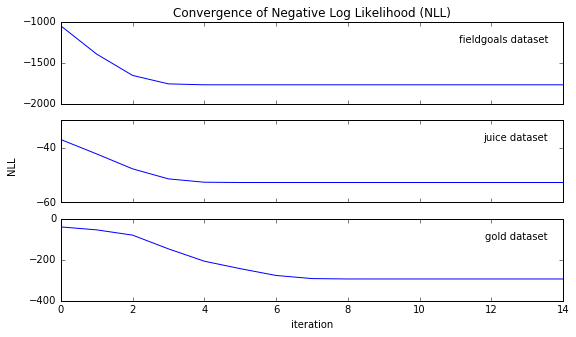

In [5]:
f, axes = plt.subplots(3, sharex=True, sharey=False, figsize=(9,5))
axes[0].set_title('Convergence of Negative Log Likelihood (NLL)')
plt.xlabel('iteration')
f.text(.05, 0.5, 'NLL', ha='center', va='center', rotation='vertical');

for i in range(3):
    axes[i].plot(np.arange(len(data[i].nll_sequence)),data[i].nll_sequence, label=data[i].name+' dataset')
    axes[i].text(.97, .75, data[i].name+' dataset', transform=axes[i].transAxes, ha='right')
    axes[i].locator_params(nbins=2, axis='y')

Summaries of each of the fitted models:

In [6]:
data[0].summary()


fieldgoals: logistic regression

Success ~ Yards + Week

Coefficient     Estimate       
--------------- ---------------
<Intercept>     6.299689734335034
Week            -0.0524336078191799
Yards           -0.1127354275434901

Converged in 8 iterations (IRLS)


In [7]:
data[1].summary()


juice: logistic regression

Growth ~ pH + Nisin + Temp + Brix

Coefficient     Estimate       
--------------- ---------------
<Intercept>     -7.246333840412728
Brix            -0.31173234862940336
Nisin           -0.066276262143294
Temp            0.1104223950074471
pH              1.885950986253122

Converged in 8 iterations (IRLS)


In [8]:
data[2].summary()


gold: logistic regression

Gold ~ As + Sb + Lineament

Coefficient     Estimate       
--------------- ---------------
<Intercept>     -7.609650868692922
As              1.2046492650019085
Lineament       3.1972564925535014
Sb              1.420954188973844

Converged in 12 iterations (IRLS)


Example of predicting new sample responses with the read_dataset() function and predict() method:

In [9]:
test_X = read_dataset('datasets/juice_test.csv', name='logistic', data_only = True)[1]
data[1].predict(test_X, use_probability=True)

array([ 0.96195407,  0.97240465,  0.35067621,  0.02940531,  0.56176085,
        0.75815753,  0.13940303,  0.07039647,  0.01166177,  0.00191276,
        0.10981691,  0.00337951,  0.13385971,  0.24290651,  0.02448657,
        0.75615076,  0.01934562,  0.29819405,  0.21170375])

<a id='Sources'></a>
### 5. Sources
1. [*Machine Learning: A Probabilistic Perspective* by Kevin R Murphy](https://www.cs.ubc.ca/~murphyk/MLbook/)
2. [GLM Lecture Notes by Germán Rodríguez](http://data.princeton.edu/wws509/notes)
3. [Logistic Regression and Newton’s Method Lecture Notes by Cosma Shalizi](http://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf)